In [1]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from collections import Counter
from scipy.spatial.distance import euclidean, cosine
from scipy.stats import entropy
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import numpy as np
from sklearn.decomposition import PCA

## Load images

In [2]:
img_paths = glob('Images/*/*.jpg')
labels = [Path(path).parent.name for path in img_paths]

label_counts = Counter(labels)

print(f'Number of categories: {len(label_counts)}')

for label, count in label_counts.items():
    print(f'Category: {label}, Number of images: {count}')

Number of categories: 20
Category: pigeon, Number of images: 45
Category: pizza, Number of images: 53
Category: platypus, Number of images: 34
Category: pyramid, Number of images: 57
Category: revolver, Number of images: 82
Category: rhino, Number of images: 59
Category: rooster, Number of images: 49
Category: saxophone, Number of images: 40
Category: schooner, Number of images: 63
Category: scissors, Number of images: 39
Category: scorpion, Number of images: 84
Category: sea_horse, Number of images: 57
Category: snoopy, Number of images: 35
Category: soccer_ball, Number of images: 64
Category: stapler, Number of images: 45
Category: starfish, Number of images: 86
Category: stegosaurus, Number of images: 59
Category: stop_sign, Number of images: 64
Category: strawberry, Number of images: 35
Category: sunflower, Number of images: 85


In [3]:
images = []
img_paths = [os.path.abspath(path) for path in img_paths]

TASK: We recommend that you (for a start) select a subset of say 4-5 categories. When you have checked that everything works you may extend to say 20 categories. For each category, the
set of images should be split in two: A training set and a test set (of equal size). The test set must not include images in the training set. When using few categories you may also limit the number of training images (to say 10) per category.

We first select 5 categories

In [4]:
# Selects the first five categories
five_categories = sorted(label_counts.keys())[:5]
print("Categories chosen:", ", ".join(five_categories))

train_imgs_5cat = []
test_imgs_5cat = []

num_images_per_category = 10 ## Limit the number of images per category to 10 for training and 10 for testing

for category in five_categories:
    category_imgs = [img_path for img_path, label in zip(img_paths, labels) if label == category]
    random.shuffle(category_imgs)
    
    # Split the images into training and test sets
    train_imgs_5cat.extend(category_imgs[:num_images_per_category])
    test_imgs_5cat.extend(category_imgs[num_images_per_category:num_images_per_category*2])

print(f'Training images: {len(train_imgs_5cat)}, Test images: {len(test_imgs_5cat)}')

Categories chosen: pigeon, pizza, platypus, pyramid, revolver
Training images: 50, Test images: 50


extend to 20 categories 

In [5]:
# Select 20 categories
twenty_categories = sorted(label_counts.keys())[:20]
print("Categories chosen:", ", ".join(twenty_categories))

train_imgs_20cat = []
test_imgs_20cat = []

for category in twenty_categories:
    category_imgs = [img_path for img_path, label in zip(img_paths, labels) if label == category]
    random.shuffle(category_imgs)
    
    num_images_per_category = len(category_imgs) // 2  # Split the images into training and test sets equally
    
    train_imgs_20cat.extend(category_imgs[:num_images_per_category])
    test_imgs_20cat.extend(category_imgs[num_images_per_category:num_images_per_category*2])

print(f'Training images: {len(train_imgs_20cat)}, Test images: {len(test_imgs_20cat)}')

Categories chosen: pigeon, pizza, platypus, pyramid, revolver, rhino, rooster, saxophone, schooner, scissors, scorpion, sea_horse, snoopy, soccer_ball, stapler, starfish, stegosaurus, stop_sign, strawberry, sunflower
Training images: 561, Test images: 561


TASK: You should extract visual words using SIFT descriptors (ignoring position, orientation and scale) or similar descriptors extracted at interest points. To compute the descriptors, we recommend to use OpenCV’s sift, but other options are possible.

NOTE TO SELF(can delete) : SIFT (Scale-Invariant Feature Transform) - detect and describe local features in images. 

Scale-space Extrema Detection: Create a series of images by applying Gaussian blur with increasing σ. Subtract each adjacent pair of images to get the DoG images. Identify local maxima and minima in the DoG images by comparing each pixel to its neighbors in both the current image and adjacent scales.

Keypoint Localization: Fit a quadratic function to the local sample points to determine the interpolated location of the extremum. Discard keypoints with low contrast (below a threshold) or those that are poorly localized along edges (using the Hessian matrix).

Orientation Assignment: For each keypoint, consider a region around it. Compute the gradient magnitude and orientation for each pixel in the region. Create a histogram of gradient orientations (typically 36 bins covering 360 degrees).
Assign the dominant orientation(s) to the keypoint. If there are multiple peaks in the histogram, create multiple keypoints with different orientations.

Keypoint Descriptor: Take a 16x16 window around the keypoint, oriented according to the keypoint's orientation.
Divide this window into 4x4 sub-regions. For each sub-region, compute a histogram of gradient orientations (typically 8 bins).
Concatenate these histograms to form a 128-dimensional vector (4x4x8).

Matching: For each keypoint descriptor in one image, find the closest descriptor in the other image using a distance metric 
Apply a ratio test to filter out poor matches (e.g., the ratio of the distance to the closest neighbor to the distance of the second closest neighbor should be below a threshold).

In [6]:
def compute_sift_descriptors(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors


train_descriptors = []
for img_path in train_imgs_20cat: #we take the train set with 20 categories
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    descriptors = compute_sift_descriptors(img)
    if descriptors is not None:
        train_descriptors.append(descriptors)

# Concatenate the descriptors into a matrix, one descriptor per row
train_descriptors_matrix = np.vstack(train_descriptors)


print(f'Total number of training descriptors for the training set with 20 categories: {train_descriptors_matrix.shape[0]}')

Total number of training descriptors for the training set with 20 categories: 244310


In [7]:
train_descriptors_small = []
for img_path in train_imgs_5cat: #we take the train set with 5 categories
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    descriptors = compute_sift_descriptors(img)
    if descriptors is not None:
        train_descriptors_small.append(descriptors)

train_descriptors_matrix_small = np.vstack(train_descriptors_small)

print(f'Total number of training descriptors for the training set with 5 categories: {train_descriptors_matrix_small.shape[0]}')

Total number of training descriptors for the training set with 5 categories: 24555


In [8]:
# print out one of the descriptors
print(train_descriptors_matrix[0])

[  2.   1.   0.   1.  27.  25.   2.   0. 137.  58.   0.   0.   1.   4.
   2.   3. 137. 137.   9.   3.   0.   0.   0.   0.   3.  19.  17.  18.
   3.   0.   0.   0.   0.   0.   0.   0.  18.  84.  13.   0. 137.  18.
   0.   0.   0.  21.  21.  28. 137.  88.   1.   0.   0.   0.   0.  17.
  22.  30.  10.   5.   1.   0.   0.   1.   0.   0.   0.   0.  20. 137.
  29.   1.  65.   1.   0.   0.   0.  32.  58. 113. 137.   6.   0.   0.
   0.   0.   2. 137.  25.   4.   1.   1.   1.   0.   2.   9.   0.   0.
   0.   0.   3. 129.  59.   1.  10.   0.   0.   0.   0.  30. 137.  92.
  26.   0.   0.   0.   0.   0.  39. 109.   2.   0.   0.   0.   0.   4.
  22.   9.]


# 1 Codebook generation

Task: In order to generate a code book, select a set of training images. Then Extract
SIFT features from the training images (ignore position, orientation and scale).
The SIFT features should be concatenated into a matrix, one descriptor per row.
Then you should run the k-means clustering algorithm on the subset of training
descriptors to extract good prototype (visual word) clusters. A reasonable k
should be small (say between 200 and 500) for a small number of categories
(say 5) and larger (say between 500 and 2000) for a larger number of categories.
Also, a good value of k may depend on the complexity of your data. You should
experiment with a few different values of k (but beware that this can be rather
time-consuming).

Once clustering has been obtained, classify each training descriptor to the
closest cluster centers) and form the bag of words (BoW) for each image in the
image training set.

We are first evaluating which is the best value for k for the subset with 5 categories. We report the Silhouette score.
The Silhouette score is a metric used to evaluate the quality of clustering. It measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The score ranges from -1 to 1. 1: Indicates that the sample is far away from the neighboring clusters and well matched to its own cluster. 0: Indicates that the sample is on or very close to the decision boundary between two neighboring clusters. -1: Indicates that the sample might have been assigned to the wrong cluster

### Evaluate best k means for 5 categories

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

scores_5_cat = []
sse_5_cat = []
cos_sim_matrices = []

def evaluate_k_means(descriptors, k_values):
    best_k = None
    best_score = -1
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(descriptors)
        labels = kmeans.labels_
        score = silhouette_score(descriptors, labels)
        scores_5_cat.append(score)
        sse = kmeans.inertia_  # Sum of squared distances of samples to their closest cluster center.
        sse_5_cat.append(sse)
       
        print(f'k={k}, Silhouette Score={score}, SSE={sse}')
        if score > best_score:
            best_score = score
            best_k = k

        # Calculate cosine similarity between cluster centroids
        centroids = kmeans.cluster_centers_
        cos_sim_matrix = cosine_similarity(centroids)
        cos_sim_matrices.append(cos_sim_matrix)
        print(f'Cosine Similarity Matrix for k={k}:\n{cos_sim_matrix}')
        
    return best_k

# Use the original descriptors 
descriptors = train_descriptors_matrix_small

k_values_5cat = range(200, 1001, 100)
best_k_5cat = evaluate_k_means(descriptors, k_values_5cat)
print(f'Best k for 5 categories: {best_k_5cat}')

k=200, Silhouette Score=0.03749324753880501, SSE=1890141696.0
Cosine Similarity Matrix for k=200:
[[1.0000001  0.61672574 0.6060446  ... 0.6250747  0.85410386 0.5662275 ]
 [0.61672574 1.0000001  0.6370512  ... 0.62625504 0.7502519  0.56315124]
 [0.6060446  0.6370512  1.         ... 0.689451   0.70012754 0.6452207 ]
 ...
 [0.6250747  0.62625504 0.689451   ... 0.99999994 0.7953181  0.67589515]
 [0.85410386 0.7502519  0.70012754 ... 0.7953181  0.99999994 0.6873723 ]
 [0.5662275  0.56315124 0.6452207  ... 0.67589515 0.6873723  1.0000002 ]]
k=300, Silhouette Score=0.031839191913604736, SSE=1809522048.0
Cosine Similarity Matrix for k=300:
[[0.9999998  0.6885324  0.665336   ... 0.65395516 0.66623956 0.58288497]
 [0.6885324  1.0000002  0.61695445 ... 0.5792355  0.71860605 0.6107564 ]
 [0.665336   0.61695445 0.9999999  ... 0.5873106  0.55625486 0.5981126 ]
 ...
 [0.65395516 0.5792355  0.5873106  ... 1.0000001  0.5623621  0.8883905 ]
 [0.66623956 0.71860605 0.55625486 ... 0.5623621  0.99999994 0

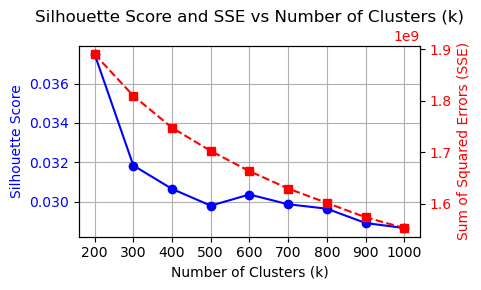

In [10]:
fig, ax1 = plt.subplots(figsize=(5, 3))

# Plot Silhouette Score
ax1.plot(k_values_5cat, scores_5_cat, marker='o', linestyle='-', color='b', label='Silhouette Score')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(k_values_5cat)
ax1.grid(True)

# Create a second y-axis for SSE
ax2 = ax1.twinx()
ax2.plot(k_values_5cat, sse_5_cat, marker='s', linestyle='--', color='r', label='SSE')
ax2.set_ylabel('Sum of Squared Errors (SSE)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a title
plt.title('Silhouette Score and SSE vs Number of Clusters (k)')

# Show the plot
fig.tight_layout()
plt.show()

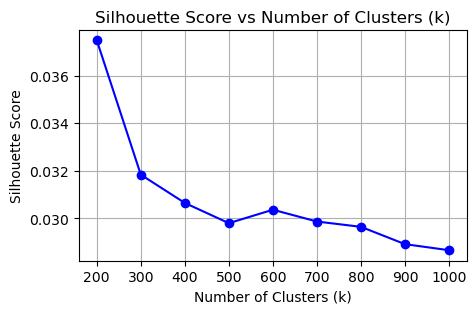

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3)) 
plt.plot(k_values_5cat, scores_5_cat, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters (k)')
plt.xticks(k_values_5cat)
plt.grid(True)
plt.show()

### Evaluate best k means for 20 categories

In [13]:
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

scores_20_cat = []
sse_20_cat = []

def evaluate_k_means_fast(descriptors, k_values):
    best_k = None
    best_score = -1
    
    
    for k in k_values:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=500).fit(descriptors)
        labels = kmeans.labels_
        score = silhouette_score(descriptors, labels, sample_size=min(1000, len(descriptors)))  # Sample to speed up
        scores_20_cat.append(score)
        sse = kmeans.inertia_  # Sum of squared distances of samples to their closest cluster center.
        sse_20_cat.append(sse)
        print(f'k={k}, Silhouette Score={score}')
        
        if score > best_score:
            best_score = score
            best_k = k
    
    return best_k, scores_20_cat

pca = IncrementalPCA(n_components=100, batch_size=500)  # Adjust batch_size as needed
print("Computing PCA for 20 categories...")
reduced_descriptors_20 = pca.fit_transform(train_descriptors_matrix)

print("Normalizing features for 20 categories...")
scaler = StandardScaler()
reduced_descriptors_20 = scaler.fit_transform(reduced_descriptors_20)

k_values_20cat = range(50, 500, 50)

result = evaluate_k_means_fast(reduced_descriptors_20, k_values_20cat)

best_k_20cat = int(result[0])  # Extract the first element of the tuple
print(f'Best k for 20 categories: {best_k_20cat}')

# not sure if the code above is correct
# print("Computing K Means for 20 categories...")
#best_k_20cat = evaluate_k_means_fast(reduced_descriptors_20, k_values_20cat)
#print(f'Best k for 20 categories: {best_k_20cat}') 

Computing PCA for 20 categories...
Normalizing features for 20 categories...
k=50, Silhouette Score=-0.08974524084214357
k=100, Silhouette Score=-0.0662332339682409
k=150, Silhouette Score=-0.11158462795400831
k=200, Silhouette Score=-0.10969486133437936
k=250, Silhouette Score=-0.10756131794912381
k=300, Silhouette Score=-0.10919718835847271
k=350, Silhouette Score=-0.09169170907451381
k=400, Silhouette Score=-0.1002906615704781
k=450, Silhouette Score=-0.10295020260436807
Best k for 20 categories: 100


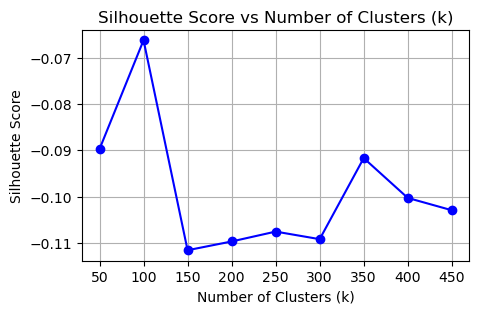

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3)) 
plt.plot(k_values_20cat, scores_20_cat, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters (k)')
plt.xticks(k_values_20cat)
plt.grid(True)
plt.show()

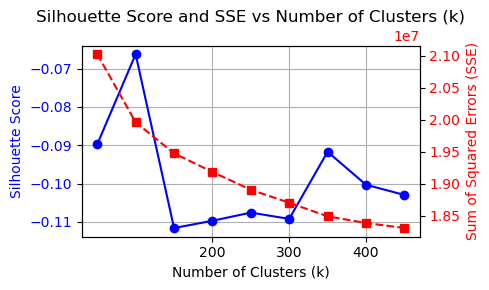

In [15]:
fig, ax1 = plt.subplots(figsize=(5, 3))

# Plot Silhouette Score
ax1.plot(k_values_20cat, scores_20_cat, marker='o', linestyle='-', color='b', label='Silhouette Score')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(k_values_5cat)
ax1.grid(True)

# Create a second y-axis for SSE
ax2 = ax1.twinx()
ax2.plot(k_values_20cat, sse_20_cat, marker='s', linestyle='--', color='r', label='SSE')
ax2.set_ylabel('Sum of Squared Errors (SSE)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a title
plt.title('Silhouette Score and SSE vs Number of Clusters (k)')

# Show the plot
fig.tight_layout()
plt.show()

In [ ]:
# This can be deleted??
# #TO DO:
# from sklearn.cluster import MiniBatchKMeans
# from joblib import Parallel, delayed

# def evaluate_k_means_minibatch(descriptors, k_values):
#    best_k = None
#    best_score = -1

#    def evaluate_single_k(k):
#        kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=500).fit(descriptors)
#        labels = kmeans.labels_
#        score = silhouette_score(descriptors, labels)
#        return k, score

#    results = Parallel(n_jobs=-1)(delayed(evaluate_single_k)(k) for k in k_values)

#    for k, score in results:
#        print(f'k={k}, Silhouette Score={score}')
#        if score > best_score:
#            best_score = score
#            best_k = k

#    return best_k

# k_values_20cat = range(500, 2000, 500) 
# best_k_20cat = evaluate_k_means_minibatch(train_descriptors_matrix, k_values_20cat)
# print(f'Best k for the training set with 20 categories: {best_k_20cat}')

Then we implement the k-means clustering on the training descriptors for the 2 different subsets. Clustering results to classify each descriptor to the closest cluster center. Then, for each image, count the number of descriptors assigned to each cluster to form a histogram (BoW vector).

In [16]:
kmeans_5 = KMeans(n_clusters=best_k_5cat, random_state=42)
kmeans_5.fit(train_descriptors_matrix_small)

visual_words = kmeans_5.cluster_centers_ # Get the cluster centers (visual words)

print(f'Number of visual words (clusters): {visual_words.shape[0]}')

Number of visual words (clusters): 200


In [17]:
# not sure if this is correct
kmeans_20 = KMeans(n_clusters=best_k_20cat, random_state=42)
kmeans_20.fit(train_descriptors_matrix)

visual_words_20 = kmeans_20.cluster_centers_

print(f'Number of visual words (clusters): {visual_words_20.shape[0]}')

Number of visual words (clusters): 100


BoW representations 

In [18]:
def form_bow(descriptors_list, kmeans):
    bow_list = []
    for descriptors in descriptors_list:
        labels = kmeans.predict(descriptors) # # Predict the closest cluster for each descriptor
        bow = np.bincount(labels, minlength=kmeans.n_clusters) # Create a histogram of cluster assignments
        bow_list.append(bow)
    return np.array(bow_list)

bow_list_5cat = form_bow(train_descriptors_small, kmeans_5)

print(f'Number of BoW vectors for the training set with 5 categories: {len(bow_list_5cat)}')

Number of BoW vectors for the training set with 5 categories: 50


In [19]:
# TO DO:
bow_list_20cat = form_bow(train_descriptors, kmeans_20)
print(f'Number of BoW vectors for the training set with 20 categories: {len(bow_list_20cat)}')

Number of BoW vectors for the training set with 20 categories: 561


# 2 Indexing

TASK: The next step consists in content indexing. For each image in the test set you
should:

• Extract the SIFT descriptors of the feature points in the image,

• Project the descriptors onto the codebook, i.e., for each descriptor the
closest cluster prototype should be found,

• Construct the generated corresponding bag of words, i.e, word histogram.
Please note that you have already performed the same steps for the training
images during codebook generation.

Now construct and save a table that would contain, per entry at least the
file name, the true category, if it belongs to the training- or test set, and the
corresponding bag of words / word histogram. The table need only be computed
once and then used repeatably in the following retrieval experiments.

In [20]:
test_descriptors_small = []
for img_path in test_imgs_5cat:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    descriptors = compute_sift_descriptors(img)
    if descriptors is not None:
        test_descriptors_small.append(descriptors)

test_descriptors_matrix_small = np.vstack(test_descriptors_small)

print(f'Total number of test descriptors for the test set with 5 categories: {test_descriptors_matrix_small.shape[0]}')

Total number of test descriptors for the test set with 5 categories: 21665


In [21]:
bow_list_test_5cat = form_bow(test_descriptors_small, kmeans_5)

print(f'Number of BoW vectors for the test set with 5 categories: {len(bow_list_test_5cat)}')

Number of BoW vectors for the test set with 5 categories: 50


In [22]:
# TO DO
#test_descriptors = []
#for img_path in test_imgs_20cat:
#    img = cv2.imread(img_path)
#    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#    descriptors = compute_sift_descriptors(img)
#    if descriptors is not None:
#        test_descriptors.append(descriptors)
#
#test_descriptors_matrix = np.vstack(test_descriptors)
#
#print(f'Total number of test descriptors for the test set with 20 categories: {test_descriptors_matrix.shape[0]}')

#bow_list_test_20cat = form_bow(test_descriptors, kmeans_20)

#print(f'Number of BoW vectors for the test set with 20 categories: {len(bow_list_test_20cat)}')

In [23]:
data_5cat = []

for img_path, bow in zip(train_imgs_5cat, bow_list_5cat):
    category = Path(img_path).parent.name
    data_5cat.append([img_path, category, 'train', bow])

for img_path, bow in zip(test_imgs_5cat, bow_list_test_5cat):
    category = Path(img_path).parent.name
    data_5cat.append([img_path, category, 'test', bow])

df_bow_5cat = pd.DataFrame(data_5cat, columns=['file_name', 'category', 'set_type', 'bow'])

df_bow_5cat.to_csv('bow_table_5cat.csv', index=False)

print("Table saved as 'bow_table_5cat.csv'")

Table saved as 'bow_table_5cat.csv'


In [24]:
df_bow_5cat.head()

,file_name,category,set_type,bow
0,c:\Users\jkeir\OneDrive\Documents\GitHub\visio...,pigeon,train,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,c:\Users\jkeir\OneDrive\Documents\GitHub\visio...,pigeon,train,"[0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 3, ..."
2,c:\Users\jkeir\OneDrive\Documents\GitHub\visio...,pigeon,train,"[2, 3, 0, 6, 3, 3, 5, 2, 2, 4, 4, 3, 1, 2, 2, ..."
3,c:\Users\jkeir\OneDrive\Documents\GitHub\visio...,pigeon,train,"[2, 2, 5, 9, 14, 11, 1, 4, 6, 10, 7, 15, 7, 12..."
4,c:\Users\jkeir\OneDrive\Documents\GitHub\visio...,pigeon,train,"[3, 8, 1, 1, 1, 0, 3, 1, 3, 2, 3, 2, 0, 3, 2, ..."


In [25]:
#TO DO
#data_20cat = []
#
#for img_path, bow in zip(train_imgs_20cat, bow_list_20cat):
#    category = Path(img_path).parent.name
#    data_20cat.append([img_path, category, 'train', bow])
#
#for img_path, bow in zip(test_imgs_20cat, bow_list_test_20cat):
#    category = Path(img_path).parent.name
#    data_20cat.append([img_path, category, 'test', bow])
#
#df_bow_20cat = pd.DataFrame(data_20cat, columns=['file_name', 'category', 'set_type', 'bow'])
#
#df_bow_20cat.to_csv('bow_table_20cat.csv', index=False)
#
#print("Table saved as 'bow_table_20cat.csv'")

# 3 Retrieving

TASK: Finally, you should implement retrieving of images using some of the similarity
measures discussed in the course slides. You may use: 

• common words

• tf-ifd similarity

• Bhattacharyya distance or Kullback-Leibler divergence

Please argue for your choice or report the differences in result when applying
the different measures.

Your report should show commented results for two experiments. 

In the first
you consider retrieving training images. 

In the second you test how well you
can classify test images. Otherwise the two test are identical. 

For each test you
should count:
• The mean reciprocal rank (i.e. the average across all queries of 1/ranki ,
where ranki is the rank position of the first correct category for the i’th
query).
• How often (in per cent) the correct category is in top-3

5 category subset

In [26]:
df = pd.read_csv('bow_table_5cat.csv')

In [27]:
def parse_bow(bow_string):
    """
    Parses a bag-of-words (BOW) string representation into a NumPy array.

    Parameters:
    - bow_string: str, the BOW string representation with numbers separated by spaces.

    Returns:
    - NumPy array of integers representing the BOW vector.
    """
    clean_bow = bow_string.replace('\n', ' ').replace('  ', ' ').strip('[]')
    bow_list = [int(x) for x in clean_bow.split()]
    return np.array(bow_list)


def common_words_similarity(bow1, bow2):
    """
    Computes the similarity between two BOW vectors based on the number of common words.

    Parameters:
    - bow1: NumPy array, the first BOW vector.
    - bow2: NumPy array, the second BOW vector.

    Returns:
    - Integer representing the sum of the minimum word counts for each term in the vectors.
    """
    return np.sum(np.minimum(bow1, bow2))


def compute_idf(df):
    """
    Computes the Inverse Document Frequency (IDF) for terms in the dataset.

    Parameters:
    - df: Pandas DataFrame, containing the 'bow' column with parsed BOW vectors.

    Returns:
    - NumPy array of IDF values for each term in the vocabulary.
    """
    num_docs = len(df)
    term_frequencies = np.sum(np.vstack(df['bow']), axis=0)  # Sum BOW vectors across all documents
    idf = np.log((num_docs + 1) / (1 + term_frequencies)) + 1  # Smooth IDF
    return idf


def tf_idf_similarity(bow1, bow2, idf):
    """
    Computes the cosine similarity between two TF-IDF vectors.

    Parameters:
    - bow1: NumPy array, the first BOW vector.
    - bow2: NumPy array, the second BOW vector.
    - idf: NumPy array, precomputed IDF values.

    Returns:
    - Float representing the cosine similarity between the two TF-IDF vectors.
    """
    tf_idf1 = bow1 * idf
    tf_idf2 = bow2 * idf
    return 1 - cosine(tf_idf1, tf_idf2)


def bhattacharyya_distance(bow1, bow2):
    """
    Computes the Bhattacharyya distance between two probability distributions.

    Parameters:
    - bow1: NumPy array, the first BOW vector.
    - bow2: NumPy array, the second BOW vector.

    Returns:
    - Float representing the Bhattacharyya distance.
    """
    return -np.log(np.sum(np.sqrt(bow1 * bow2)))


def kl_divergence(bow1, bow2):
    """
    Computes the Kullback-Leibler (KL) divergence between two probability distributions.

    Parameters:
    - bow1: NumPy array, the first probability distribution.
    - bow2: NumPy array, the second probability distribution.

    Returns:
    - Float representing the KL divergence.
    """
    return entropy(bow1, bow2)


def retrieve_images(query_bow, df, similarity_measure):
    """
    Retrieves images from a dataset based on similarity to a query BOW vector.

    Parameters:
    - query_bow: NumPy array, the query BOW vector.
    - df: Pandas DataFrame, containing images and their BOW vectors.
    - similarity_measure: Function, the similarity measure to use for comparison.

    Returns:
    - List of tuples containing file name, category, and similarity score, sorted by similarity.
    """
    similarities = []
    for _, row in df.iterrows():
        bow = row['bow']  # Use the parsed NumPy array directly
        similarity = similarity_measure(query_bow, bow)
        similarities.append((row['file_name'], row['category'], similarity))
    similarities.sort(key=lambda x: x[2], reverse=True)
    return similarities


def evaluate_retrieval(df, similarity_measure):
    """
    Evaluates the retrieval performance of a similarity measure using Mean Reciprocal Rank (MRR) and Top-3 accuracy.

    Parameters:
    - df: Pandas DataFrame, containing images and their BOW vectors.
    - similarity_measure: Function, the similarity measure to use for comparison.

    Returns:
    - mrr: Float, the Mean Reciprocal Rank across all queries.
    - top3_percentage: Float, the percentage of queries where the correct category is in the top 3 results.
    """
    mrr = 0
    top3_count = 0
    num_queries = len(df)

    for query_index in range(num_queries):
        query_bow = df.iloc[query_index]['bow']
        query_category = df.iloc[query_index]['category']
        results = retrieve_images(query_bow, df, similarity_measure)

        # Calculate rank of the first correct category
        rank = next((i for i, result in enumerate(results) if result[1] == query_category), None)
        if rank is not None:
            mrr += 1 / (rank + 1)
            if rank < 3:
                top3_count += 1

    mrr /= num_queries
    top3_percentage = (top3_count / num_queries) * 100
    return mrr, top3_percentage

In [28]:
# Function to perform experiments and print results
def perform_experiment(set_name, dataset, similarity_measures):
    print(f"\n--- Results for {set_name} Set ---")
    for name, similarity_measure in similarity_measures.items():
        mrr, top3 = evaluate_retrieval(dataset, similarity_measure)
        print(f"Similarity Measure: {name}")
        print(f"  - Mean Reciprocal Rank (MRR): {mrr:.4f}")
        print(f"  - Top-3 Accuracy: {top3:.2f}%")

In [29]:
df['bow'] = df['bow'].apply(parse_bow)

idf = compute_idf(df)

### Experiment 1 - retrieving training images

In [30]:
training_set = df[df['set_type'] == 'train']

training_set['bow'] = training_set['bow'].apply(parse_bow)

similarity_measures = { 'Common Words': common_words_similarity, 
                       'TF-IDF': lambda bow1, bow2: tf_idf_similarity(bow1, bow2, idf), 
                       'Bhattacharyya': bhattacharyya_distance, 
                       'KL Divergence': kl_divergence }

perform_experiment("Training", training_set, similarity_measures)


AttributeError: 'numpy.ndarray' object has no attribute 'replace'

### Experiment 2 - retrieving test images

In [130]:
test_set = df[df['set_type'] == 'test']

test_set['bow'] = test_set['bow'].apply(parse_bow)

perform_experiment("Test", test_set, similarity_measures)

/tmp/ipykernel_102355/4224355731.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['bow'] = test_set['bow'].apply(parse_bow)



--- Results for Test Set ---
Similarity Measure: Common Words
  - Mean Reciprocal Rank (MRR): 1.0000
  - Top-3 Accuracy: 100.00%
Similarity Measure: TF-IDF
  - Mean Reciprocal Rank (MRR): 1.0000
  - Top-3 Accuracy: 100.00%
Similarity Measure: Bhattacharyya
  - Mean Reciprocal Rank (MRR): 0.3556
  - Top-3 Accuracy: 32.00%
Similarity Measure: KL Divergence
  - Mean Reciprocal Rank (MRR): 0.2393
  - Top-3 Accuracy: 20.00%
